# Linear adult

In [1]:
import os # need to happen before loading numpy
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=8
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=8
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=8
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=8

In [2]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from on_manifold import OnManifoldExplainer, IndExplainer

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl
from graphviz import Digraph
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, LinearRegression

In [3]:
X, y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True) # human readable feature values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression().fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [26]:
for name, c in zip(list(X.columns), list(model.coef_[0])):
    print(name, c)

Age -0.002288377402866901
Workclass -0.195213407433942
Education-Num 0.14815335606738878
Marital Status -0.5323133667164592
Occupation -0.004318199326061284
Relationship 0.48692318773300286
Race -0.20271320780091187
Sex 0.09035553558669762
Capital Gain 0.00033331880819852556
Capital Loss 0.00070709773225454
Hours per week 0.008008260154342832
Country -0.0488898213095558


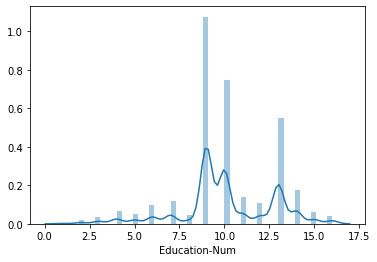

In [6]:
sns.distplot(X['Education-Num'])

In [7]:
causal_links = CausalLinks()
categorical_feature_names = [] #['Race', 'Sex'] # linear model doesn't handle categorical features
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted income >50k' # 'predicted hazard'
feature_names = list(X.columns)
f = lambda x: x.dot(model.coef_.reshape(-1, 1)).ravel() + model.intercept_ # model.predict_proba(x)[:, 1] # logit is linear log(p / 1-p)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_linear_f(feature_names, f))
causal_links.add_causes_effects('Education-Num', 'Age', lambda e: e) # age linearly increases with education num
A = ['Age', 'Sex', 'Country', 'Race']
D = list(set(feature_names) - set(A) - set(['Education-Num']))
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name, method='linear')

learning dependency for Workclass: 100%|██████████| 7/7 [00:00<00:00, 70.54it/s]


In [8]:
n_explain = 100
cf_flow_adult = GraphExplainer(causal_graph, X, nruns=1).shap_values(X[:n_explain])

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 42.81it/s]


In [9]:
explainer = OnManifoldExplainer(f, X, nruns=100, sigma_sq=0.1) 
cf_on_manifold_adult = explainer.shap_values(X[:n_explain])

  0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [19]:
explainer = IndExplainer(f, X, nruns=100)
cf_ind_adult = explainer.shap_values(X[:n_explain])

100%|██████████| 100/100 [00:00<00:00, 1680.34it/s]


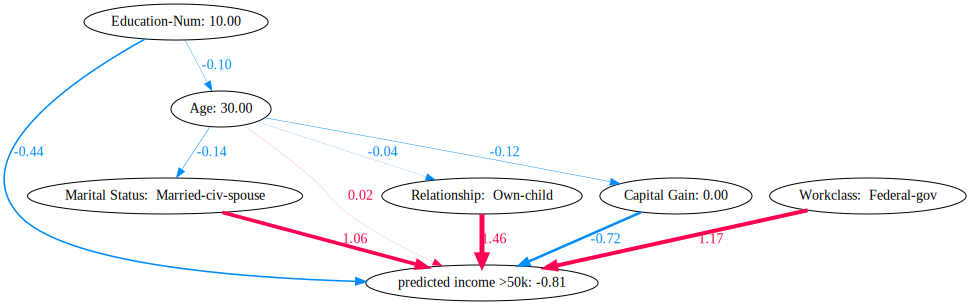

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
33,30.0,1,10.0,2,1,3,4,1,0.0,0.0,40.0,39


In [29]:
sample_ind = 33
cf_flow_adult.draw(sample_ind, max_display=10)
X.iloc[[0, sample_ind]]

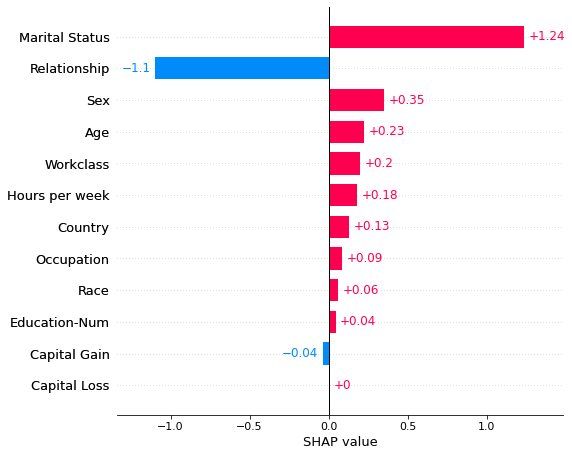

In [11]:
cf_on_manifold_adult.draw(sample_ind)

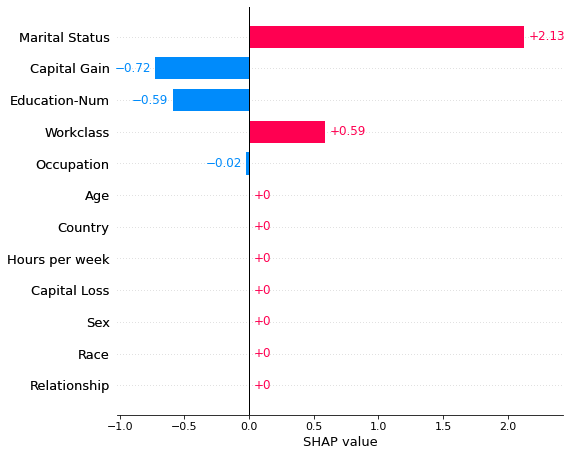

In [12]:
cf_ind_adult.draw(sample_ind)

ASV


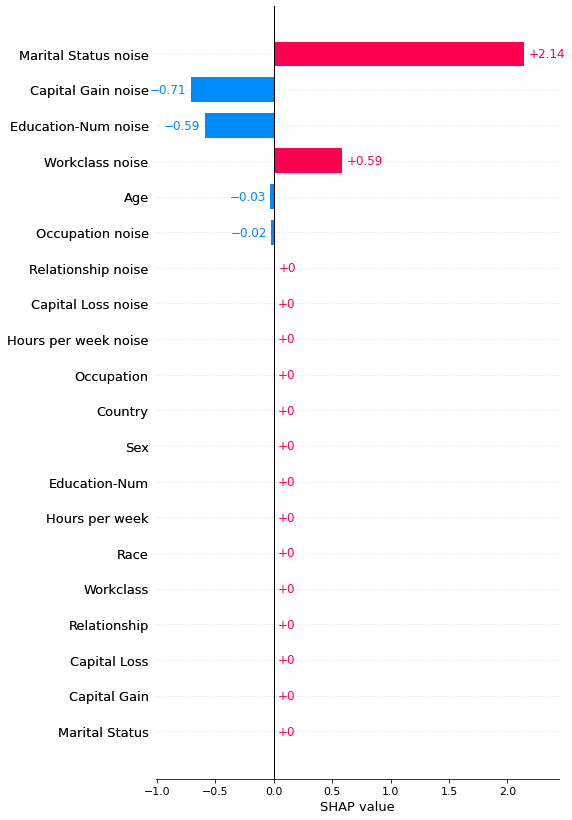

In [13]:
# asv
print('ASV')
def prepare_bar_asv(target_node, edge_credit, sample_ind, graph):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    
    for node in graph: # add internal nodes
        if node.is_target_node or len(node.args) == 0: continue
        b.values.append(0)
        b.input_names.append(node.name)
        
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_flow_adult.graph if i.is_target_node][0]
edge_credit = cf_flow_adult.get_asv_edge_credit(sample_ind)

b = prepare_bar_asv(target_node, edge_credit, sample_ind, cf_flow_adult.graph)
shap.plots.bar(b, max_display=None, show=False)
plt.tight_layout()
plt.show()

In [14]:
def get_indirect_effect_flow(cf):
    d = defaultdict(int)
    ec = cf.edge_credit
    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            d[node1.name] += v[1:n_explain]

    return d

def get_effect_asv(cf):
    d = defaultdict(int)
    ec = cf.get_asv_edge_credit(aggregate=False)

    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            if node2.is_target_node:
                d[node1.name] = v[1:n_explain]

    return d

def get_error(gt, theta, allowed_nodes=None):
    diff = []
    for k in gt:
        if allowed_nodes is not None and k not in [node.name for node in allowed_nodes]:
            continue
        diff = np.hstack([diff, gt[k] - theta[k]])
    return diff

def get_effect_ind(cf):
    d = defaultdict(int)
    d.update({k:v[1:n_explain] for k, v in zip(cf.input_names, cf.values.T)})
    return d

def get_effect_manifold(cf):
    d = defaultdict(int)
    d.update({k:v[1:n_explain] for k, v in zip(cf.input_names, cf.values.T)})
    return d

def get_direct_effect_flow(cf):
    d = defaultdict(int)
    ec = cf.edge_credit
    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            if node2.is_target_node:
                d[node1.name] = v[1:n_explain]

    return d

def get_direct_effect_ground_truth(graph, X):
    gt = {}
    for n in graph:
        if n.is_target_node: continue

        intervention_on = n.name
        
        d = dict((node.name, node.baseline[1:n_explain]) for node in graph if not node.is_target_node) # background
        before = eval_graph(graph, d)

        d.update({intervention_on: n.target[1:n_explain]}) # foreground
        after = eval_graph(graph, d)

        gt[intervention_on] = after - before
    return gt

gt = get_direct_effect_ground_truth(cf_flow_adult.graph, X)
theta_ind = get_effect_ind(cf_ind_adult)
theta_manifold = get_effect_manifold(cf_on_manifold_adult)
theta_asv = get_effect_asv(cf_flow_adult)
theta_flow = get_direct_effect_flow(cf_flow_adult)

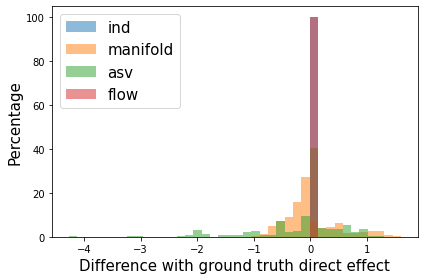

In [21]:
target_node = [node for node in cf_flow_adult.graph if node.is_target_node][0]
feature_nodes = target_node.args
feature_noise_nodes = []
for n in feature_nodes:
    corresponding_noise = [node for node in cf_flow_adult.graph if node.name == n.name + ' noise']
    if len(corresponding_noise) == 0:
        feature_noise_nodes.append(n)
    else:
        feature_noise_nodes.append(corresponding_noise[0])

errors = {
    'ind': get_error(gt, theta_ind, feature_nodes), # does not compare noise node
    'manifold': get_error(gt, theta_manifold, feature_nodes), # does not compare noise node
    'asv': get_error(gt, theta_asv, feature_noise_nodes), # replace some feature nodes with noise node
    'flow': get_error(gt, theta_flow, feature_nodes) # direct effect focus on feature nodes
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth direct effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.savefig('figures/income_direct_error.png')
plt.show()

In [16]:
def get_indirect_effect_ground_truth(graph, X):
    gt = {}
    for n in graph:
        if n.is_target_node: continue

        intervention_on = n.name
        sources = get_source_nodes(graph)

        d = dict((node.name, node.baseline[1:n_explain]) for node in sources) # background
        before = eval_graph(graph, d)

        d.update({intervention_on: n.target[1:n_explain]}) # foreground
        after = eval_graph(graph, d)

        gt[intervention_on] = after - before
    return gt

gt_indirect = get_indirect_effect_ground_truth(cf_flow_adult.graph, X)
theta_flow_indirect = get_indirect_effect_flow(cf_flow_adult)

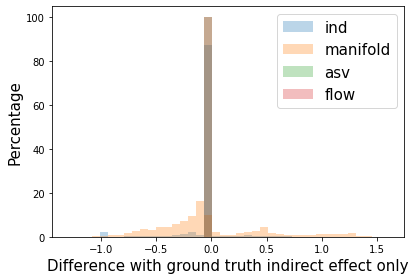

In [20]:
errors = {
    'ind': get_error(gt_indirect, theta_ind, feature_nodes),
    'manifold': get_error(gt_indirect, theta_manifold, feature_nodes),
    'asv': get_error(gt_indirect, theta_asv, feature_noise_nodes),
    'flow': get_error(gt_indirect, theta_flow_indirect, feature_nodes)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.3, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth indirect effect only', fontsize=15)
# plt.ylim(0, 300)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.savefig('figures/income_indirect_error.png')
plt.show()

1.5695990594474694

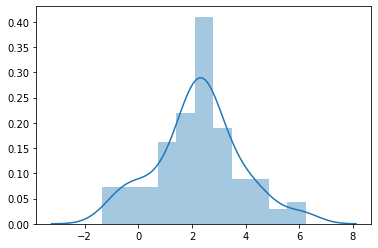

In [19]:
o = f(np.array(X)[:n_explain])
o = o[1:] - o[0]
sns.distplot(o)
np.std(o)